In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install pyclustering

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Truncated Singular Value Decomposition

## Code for Truncated SVD

In [ ]:
import numpy as np

def truncated_svd(X, k):
    X_T = np.transpose(X)
    X_X_T = np.dot(X, X_T)
    
    eig_vals, eig_vecs = np.linalg.eig(X_X_T)
    
    eig_pairs = [(eig_vals[i], eig_vecs[:,i]) for i in range(len(eig_vals))]
    eig_pairs.sort(key=lambda x: x[0], reverse=True)
    
    U = np.array([pair[1] for pair in eig_pairs])
    
    singular_values = np.sqrt(abs(eig_vals))
    
    S = np.diag(singular_values)
    
    V = np.dot(np.dot(X_T, U), np.linalg.inv(S))
    
    U = np.real(U[:,:k])
    S = np.real(S[:k,:k])
    V = np.real(V[:,:k])
    
    return U, S, V

## Generating the Data

In [ ]:
import random

X = np.random.rand(1000, 100)

print(X.shape)

(1000, 100)


## Finding optimal k

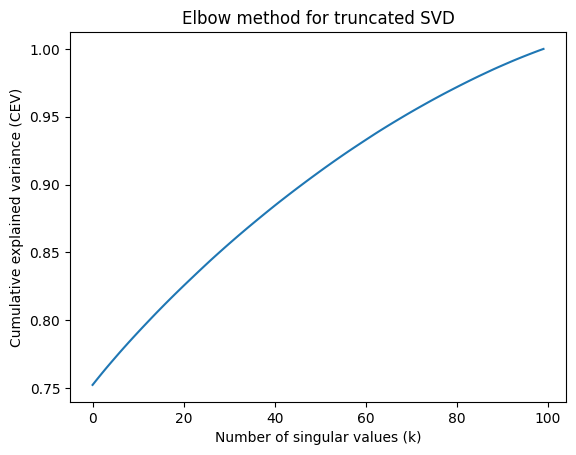

In [ ]:
import matplotlib.pyplot as plt

def truncated_svd_cev(X):
    singular_values = np.linalg.svd(X, compute_uv=False)

    cev = np.cumsum(singular_values**2) / np.sum(singular_values**2)

    return cev

cev = truncated_svd_cev(X)

plt.plot(cev)f
plt.xlabel('Number of singular values (k)')
plt.ylabel('Cumulative explained variance (CEV)')
plt.title('Elbow method for truncated SVD')
plt.show()

Optimal K is between 60 and 80

## Performing Truncated SVD on the data

In [ ]:
k = 70

TU, TS, TV = truncated_svd(X, k)

reconstructed_X = np.dot(TU, np.dot((TS), TV.T))
error = np.linalg.norm(X - reconstructed_X)
print(error)

175.41397197347064


## Plotting the reconstruction error for multiple k

In [ ]:
# k_values = range(1, min(X.shape)+1)

# reconstruction_errors = []
# for k in k_values:
#     U, S, V = truncated_svd(X, k)
#     X_reconstructed = np.dot(np.dot(U, S), V.T)
#     reconstruction_error = np.linalg.norm(X - X_reconstructed)
#     reconstruction_errors.append(reconstruction_error)

# plt.plot(k_values, reconstruction_errors)
# plt.show()

In [ ]:
U, S, V = truncated_svd(X, 70)
X_svd = X.dot(V)

Hypothesis about K was correct

## Finding optimal number of clusters using WCSS elbow method

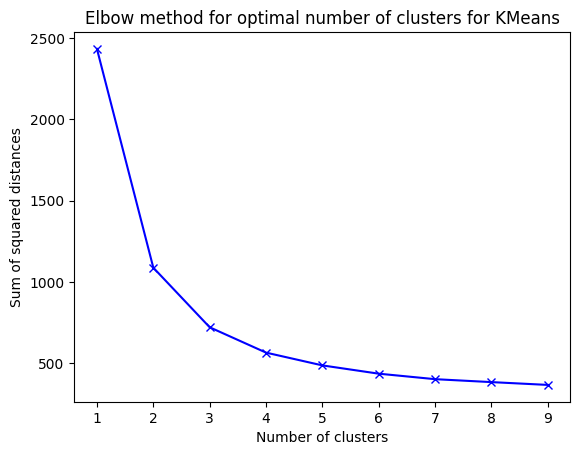

In [ ]:
from sklearn.cluster import KMeans

distortions = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_svd)
    distortions.append(kmeans.inertia_)

plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow method for optimal number of clusters for KMeans')
plt.show()

## KMeans

WCSS for X:  8072.773538264553
WCSS for truncated X:  486.0500334452871


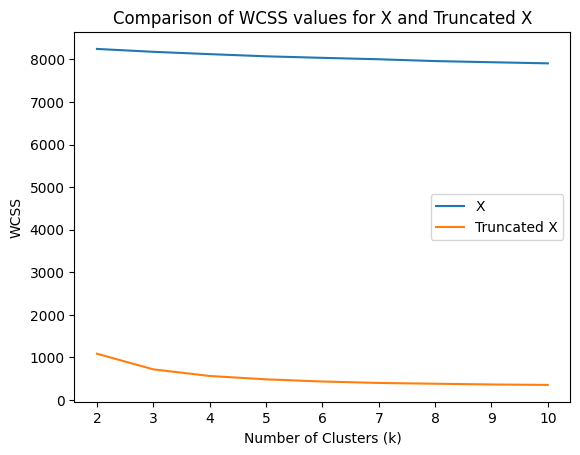

In [ ]:
k = 5

# Perform k-means clustering on the original X
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)
wcss_X = kmeans.inertia_

# Perform k-means clustering on the truncated X
kmeans_truncated = KMeans(n_clusters=k)
kmeans_truncated.fit(X_svd)
wcss_truncated_X = kmeans_truncated.inertia_

# Print the WCSS values for both X and truncated X
print("WCSS for X: ", wcss_X)
print("WCSS for truncated X: ", wcss_truncated_X)

# Compare the WCSS values for different values of k
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]
wcss_X_values = []
wcss_truncated_X_values = []

for k in k_values:
    # Perform k-means clustering on X
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    wcss_X = kmeans.inertia_
    wcss_X_values.append(wcss_X)
    
    # Perform k-means clustering on truncated X
    kmeans_truncated = KMeans(n_clusters=k)
    kmeans_truncated.fit(X_svd)
    wcss_truncated_X = kmeans_truncated.inertia_
    wcss_truncated_X_values.append(wcss_truncated_X)

plt.plot(k_values, wcss_X_values, label='X')
plt.plot(k_values, wcss_truncated_X_values, label='Truncated X')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Comparison of WCSS values for X and Truncated X')
plt.legend()
plt.show()

Plots are almost similar, hence cost of kmeans is preserved

## KMedians

In [ ]:
from pyclustering.cluster.kmedians import kmedians

k_values = range(1, 11)

wcss_values = []

for k in k_values:
    kmedians_instance = kmedians(X_svd, [k])
    kmedians_instance.process()
    wcss = kmedians_instance.get_total_wce()
    wcss_values.append(wcss)

plt.plot(k_values, wcss_values)
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method to find optimal k for KMedians')
plt.show()

# JF Lemma